# Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

from PIL import Image

from src.storage.client import DatabaseManager
from src.storage.collection import ImageCollection
from src.storage.dataset import Dataset
from src.embeddings.pretrained import FaceEmbeddings

# Connect to client

In [2]:
db_manager = DatabaseManager()
db_manager.create_client(remove_if_exists=False)

img_dim = 512
img_similiary_metric = "COSINE"
img_collection = ImageCollection(db_manager.get_client(), dimension=img_dim, metric_type=img_similiary_metric)

dataset = Dataset(
    img_folder_path="./data/img_align_celeba",
    img_identity_map_path="./data/identity_CelebA.txt"
)
img_identity_collection = dataset.images_by_identity()

em = FaceEmbeddings()

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/alex/.insightface/models/buffalo_s/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/alex/.insightface/models/buffalo_s/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/alex/.insightface/models/buffalo_s/det_500m.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/alex/.insightface/models/buffalo_s/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/alex/.insightface/models/buffalo_s/w600k_mbf.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


# Check images

In [3]:
client = db_manager.get_client()

In [4]:
client.list_collections()

['images']

In [5]:
collection_name = 'images'

client.has_collection(collection_name)
stats = client.get_collection_stats(collection_name)
entity_count = stats['row_count']

print(f'The collection has {entity_count} images inserted.')

The collection has 200024 images inserted.


# Evaluation

In [6]:
celebrity_id = 4905 # Josh Charles
img_identity_collection[celebrity_id]

['./data/img_align_celeba/000016.jpg',
 './data/img_align_celeba/004318.jpg',
 './data/img_align_celeba/010102.jpg',
 './data/img_align_celeba/016774.jpg',
 './data/img_align_celeba/022641.jpg',
 './data/img_align_celeba/026804.jpg',
 './data/img_align_celeba/034776.jpg',
 './data/img_align_celeba/036102.jpg',
 './data/img_align_celeba/037226.jpg',
 './data/img_align_celeba/039409.jpg',
 './data/img_align_celeba/070164.jpg',
 './data/img_align_celeba/076907.jpg',
 './data/img_align_celeba/078225.jpg',
 './data/img_align_celeba/096685.jpg',
 './data/img_align_celeba/099998.jpg',
 './data/img_align_celeba/100270.jpg',
 './data/img_align_celeba/101391.jpg',
 './data/img_align_celeba/110003.jpg',
 './data/img_align_celeba/112636.jpg',
 './data/img_align_celeba/114959.jpg',
 './data/img_align_celeba/118259.jpg',
 './data/img_align_celeba/131431.jpg',
 './data/img_align_celeba/135813.jpg',
 './data/img_align_celeba/144280.jpg',
 './data/img_align_celeba/145873.jpg',
 './data/img_align_celeba

## Raw image search

In [7]:
query_vector = em.get_embedding(path=r'./data/josh-charles.jpg')
result = img_collection.search(query_vectors=[query_vector], limit=5)

In [8]:
for hits in result:
    for hit in hits:
        hit_id, hit_distance = hit['id'], hit['distance']
        print(f"{hit_id=}, {hit_distance=}")

        celeb_id, img_path = hit['entity']['celeb_id'], hit['entity']['img_path']
        print(f" > celeb_id={celeb_id}")
        print(f" > img_path={img_path}")
        print()

hit_id=455152072059519800, hit_distance=0.7367151379585266
 > celeb_id=4905
 > img_path=./data/img_align_celeba/022641.jpg

hit_id=455152072059519801, hit_distance=0.7256599068641663
 > celeb_id=4905
 > img_path=./data/img_align_celeba/026804.jpg

hit_id=455152072059519806, hit_distance=0.7197667956352234
 > celeb_id=4905
 > img_path=./data/img_align_celeba/070164.jpg

hit_id=455152072059519815, hit_distance=0.7189067602157593
 > celeb_id=4905
 > img_path=./data/img_align_celeba/114959.jpg

hit_id=455152072059519820, hit_distance=0.718002200126648
 > celeb_id=4905
 > img_path=./data/img_align_celeba/145873.jpg



In [9]:
image_paths = [hit['entity']['img_path'] for hits in result for hit in hits]
images = [mpimg.imread(path) for path in image_paths]

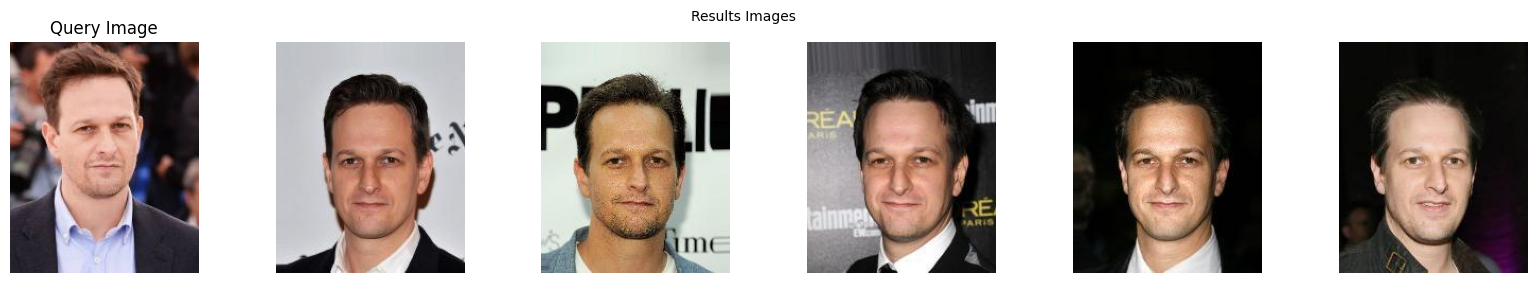

In [10]:
# Create a figure with 1 row and 6 columns
fig, axs = plt.subplots(1, 6, figsize=(20, 3))  # Adjust the figure size as needed

# Plot the first image with its title
axs[0].imshow(mpimg.imread(r'./data/josh-charles.jpg'), cmap='gray')
axs[0].set_title('Query Image')
axs[0].axis('off')  # Hide axes for cleaner look

counter = 0
# Plot the rest of the images
for ax in axs[1:]:
    ax.imshow(images[counter], cmap='gray')  # Replace images[1] with your specific images as necessary
    ax.axis('off')
    counter = counter + 1

# Set a common title for the last five images
fig.text(0.5, 0.95, 'Results Images', ha='center')  # Adjust y position as necessary for visibility

plt.show()

## Augmented Image Search

In [11]:
def salt_and_pepper(image, prob):
    """
    Add salt and pepper noise to an image.
    :param image: numpy array of the image
    :param prob: Probability of the noise
    :return: Noisy image
    """
    # Check if image is grayscale or color
    output = np.copy(image)
    if len(image.shape) == 2:  # grayscale image
        black = 0
        white = 255
    else:  # color image
        black = np.array([0, 0, 0], dtype='uint8')
        white = np.array([255, 255, 255], dtype='uint8')
    
    # Prob of each pixel to be black
    probs = np.random.random(image.shape[:2])
    output[probs < (prob / 2)] = black
    # Prob of each pixel to be white
    output[probs > 1 - (prob / 2)] = white
    return output

In [12]:
raw_image = Image.open(r'./data/josh-charles.jpg')

In [13]:
rotated_img = raw_image.rotate(45)
flipped_img = raw_image.transpose(Image.FLIP_LEFT_RIGHT)
width, height = raw_image.size
elongated_img = raw_image.resize((int(width * 0.8), int(height * 1.5)))
noisy_img = salt_and_pepper(np.array(raw_image), prob=0.03)  # 5% probability

In [14]:
# Step 3: Save the augmented images locally
rotated_img.save(r'./data/josh-charles-rotated.jpg')
flipped_img.save(r'./data/josh-charles-flipped.jpg')
elongated_img.save(r'./data/josh-charles-elongated.jpg')
Image.fromarray(noisy_img).save(r'./data/josh-charles-noisy.jpg')

### Rotated

In [15]:
query_vector = em.get_embedding(path=r'./data/josh-charles-rotated.jpg')
result = img_collection.search(query_vectors=[query_vector], limit=5)

In [16]:
for hits in result:
    for hit in hits:
        hit_id, hit_distance = hit['id'], hit['distance']
        print(f"{hit_id=}, {hit_distance=}")

        celeb_id, img_path = hit['entity']['celeb_id'], hit['entity']['img_path']
        print(f" > celeb_id={celeb_id}")
        print(f" > img_path={img_path}")
        print()

hit_id=455152072059519800, hit_distance=0.6636757850646973
 > celeb_id=4905
 > img_path=./data/img_align_celeba/022641.jpg

hit_id=455152072059519804, hit_distance=0.6406274437904358
 > celeb_id=4905
 > img_path=./data/img_align_celeba/037226.jpg

hit_id=455152072059519820, hit_distance=0.634149968624115
 > celeb_id=4905
 > img_path=./data/img_align_celeba/145873.jpg

hit_id=455152072059519823, hit_distance=0.6320599317550659
 > celeb_id=4905
 > img_path=./data/img_align_celeba/159834.jpg

hit_id=455152072059519799, hit_distance=0.6296186447143555
 > celeb_id=4905
 > img_path=./data/img_align_celeba/016774.jpg



In [17]:
image_paths = [hit['entity']['img_path'] for hits in result for hit in hits]
images = [mpimg.imread(path) for path in image_paths]

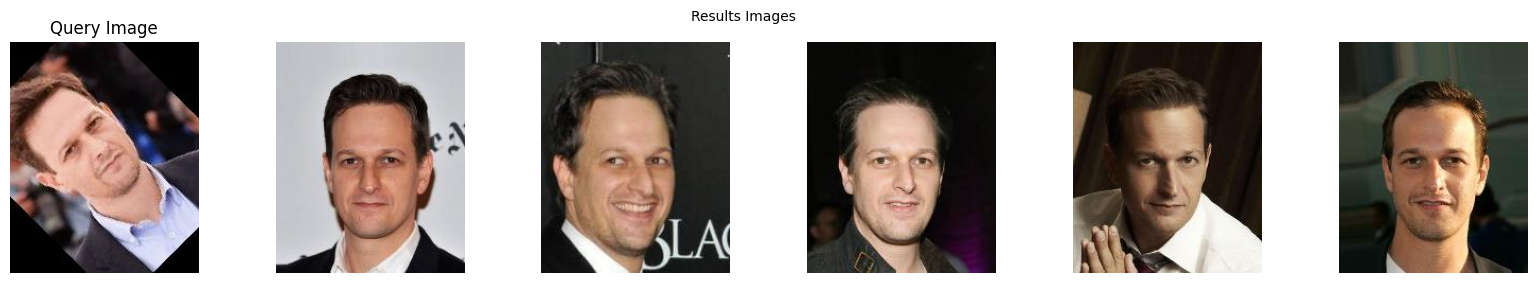

In [18]:
# Create a figure with 1 row and 6 columns
fig, axs = plt.subplots(1, 6, figsize=(20, 3))  # Adjust the figure size as needed

# Plot the first image with its title
axs[0].imshow(mpimg.imread(r'./data/josh-charles-rotated.jpg'), cmap='gray')
axs[0].set_title('Query Image')
axs[0].axis('off')  # Hide axes for cleaner look

counter = 0
# Plot the rest of the images
for ax in axs[1:]:
    ax.imshow(images[counter], cmap='gray')  # Replace images[1] with your specific images as necessary
    ax.axis('off')
    counter = counter + 1

# Set a common title for the last five images
fig.text(0.5, 0.95, 'Results Images', ha='center')  # Adjust y position as necessary for visibility

plt.show()

### Flipped

In [19]:
query_vector = em.get_embedding(path=r'./data/josh-charles-flipped.jpg')
result = img_collection.search(query_vectors=[query_vector], limit=5)

In [20]:
for hits in result:
    for hit in hits:
        hit_id, hit_distance = hit['id'], hit['distance']
        print(f"{hit_id=}, {hit_distance=}")

        celeb_id, img_path = hit['entity']['celeb_id'], hit['entity']['img_path']
        print(f" > celeb_id={celeb_id}")
        print(f" > img_path={img_path}")
        print()

hit_id=455152072059519800, hit_distance=0.720284104347229
 > celeb_id=4905
 > img_path=./data/img_align_celeba/022641.jpg

hit_id=455152072059519801, hit_distance=0.7119742631912231
 > celeb_id=4905
 > img_path=./data/img_align_celeba/026804.jpg

hit_id=455152072059519815, hit_distance=0.7099798917770386
 > celeb_id=4905
 > img_path=./data/img_align_celeba/114959.jpg

hit_id=455152072059519806, hit_distance=0.709562361240387
 > celeb_id=4905
 > img_path=./data/img_align_celeba/070164.jpg

hit_id=455152072059519796, hit_distance=0.7070256471633911
 > celeb_id=4905
 > img_path=./data/img_align_celeba/000016.jpg



In [21]:
image_paths = [hit['entity']['img_path'] for hits in result for hit in hits]
images = [mpimg.imread(path) for path in image_paths]

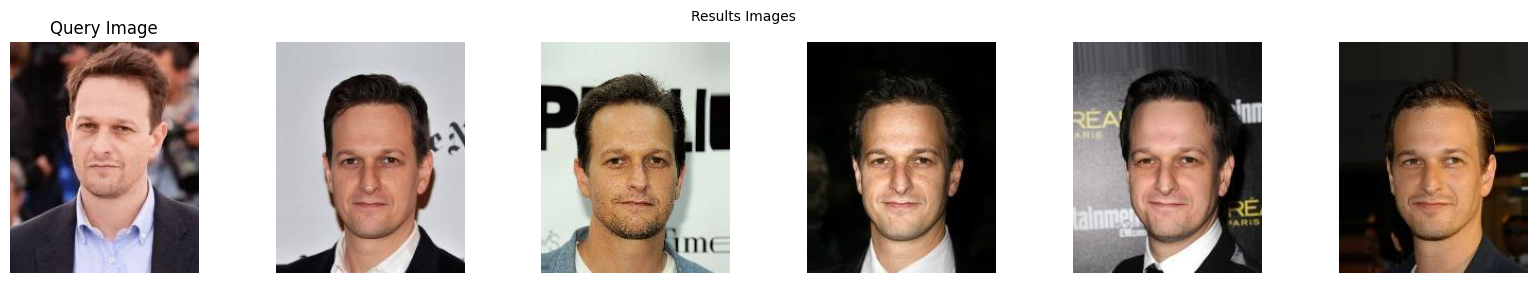

In [22]:
# Create a figure with 1 row and 6 columns
fig, axs = plt.subplots(1, 6, figsize=(20, 3))  # Adjust the figure size as needed

# Plot the first image with its title
axs[0].imshow(mpimg.imread(r'./data/josh-charles-flipped.jpg'), cmap='gray')
axs[0].set_title('Query Image')
axs[0].axis('off')  # Hide axes for cleaner look

counter = 0
# Plot the rest of the images
for ax in axs[1:]:
    ax.imshow(images[counter], cmap='gray')  # Replace images[1] with your specific images as necessary
    ax.axis('off')
    counter = counter + 1

# Set a common title for the last five images
fig.text(0.5, 0.95, 'Results Images', ha='center')  # Adjust y position as necessary for visibility

plt.show()

### Elongated

In [23]:
query_vector = em.get_embedding(path=r'./data/josh-charles-elongated.jpg')
result = img_collection.search(query_vectors=[query_vector], limit=5)

In [24]:
for hits in result:
    for hit in hits:
        hit_id, hit_distance = hit['id'], hit['distance']
        print(f"{hit_id=}, {hit_distance=}")

        celeb_id, img_path = hit['entity']['celeb_id'], hit['entity']['img_path']
        print(f" > celeb_id={celeb_id}")
        print(f" > img_path={img_path}")
        print()

hit_id=455152072059519800, hit_distance=0.5686514377593994
 > celeb_id=4905
 > img_path=./data/img_align_celeba/022641.jpg

hit_id=455152072059519806, hit_distance=0.5597593784332275
 > celeb_id=4905
 > img_path=./data/img_align_celeba/070164.jpg

hit_id=455152072059519796, hit_distance=0.5537173748016357
 > celeb_id=4905
 > img_path=./data/img_align_celeba/000016.jpg

hit_id=455152072059519808, hit_distance=0.5488185286521912
 > celeb_id=4905
 > img_path=./data/img_align_celeba/078225.jpg

hit_id=455152072059519804, hit_distance=0.5448217391967773
 > celeb_id=4905
 > img_path=./data/img_align_celeba/037226.jpg



In [25]:
image_paths = [hit['entity']['img_path'] for hits in result for hit in hits]
images = [mpimg.imread(path) for path in image_paths]

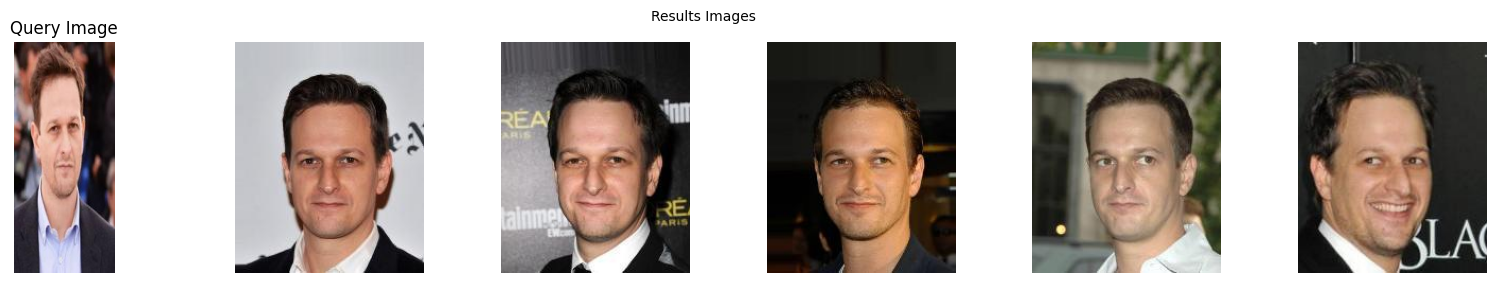

In [26]:
# Create a figure with 1 row and 6 columns
fig, axs = plt.subplots(1, 6, figsize=(20, 3))  # Adjust the figure size as needed

# Plot the first image with its title
axs[0].imshow(mpimg.imread(r'./data/josh-charles-elongated.jpg'), cmap='gray')
axs[0].set_title('Query Image')
axs[0].axis('off')  # Hide axes for cleaner look

counter = 0
# Plot the rest of the images
for ax in axs[1:]:
    ax.imshow(images[counter], cmap='gray')  # Replace images[1] with your specific images as necessary
    ax.axis('off')
    counter = counter + 1

# Set a common title for the last five images
fig.text(0.5, 0.95, 'Results Images', ha='center')  # Adjust y position as necessary for visibility

plt.show()

### Salt and pepper

In [27]:
query_vector = em.get_embedding(path=r'./data/josh-charles-noisy.jpg')
result = img_collection.search(query_vectors=[query_vector], limit=5)

In [28]:
for hits in result:
    for hit in hits:
        hit_id, hit_distance = hit['id'], hit['distance']
        print(f"{hit_id=}, {hit_distance=}")

        celeb_id, img_path = hit['entity']['celeb_id'], hit['entity']['img_path']
        print(f" > celeb_id={celeb_id}")
        print(f" > img_path={img_path}")
        print()

hit_id=455152072059519809, hit_distance=0.5857763290405273
 > celeb_id=4905
 > img_path=./data/img_align_celeba/096685.jpg

hit_id=455152072059519815, hit_distance=0.5676366686820984
 > celeb_id=4905
 > img_path=./data/img_align_celeba/114959.jpg

hit_id=455152072059519825, hit_distance=0.5466057658195496
 > celeb_id=4905
 > img_path=./data/img_align_celeba/162377.jpg

hit_id=455152072059519818, hit_distance=0.5206986665725708
 > celeb_id=4905
 > img_path=./data/img_align_celeba/135813.jpg

hit_id=455152072059519814, hit_distance=0.5204188823699951
 > celeb_id=4905
 > img_path=./data/img_align_celeba/112636.jpg



In [29]:
image_paths = [hit['entity']['img_path'] for hits in result for hit in hits]
images = [mpimg.imread(path) for path in image_paths]

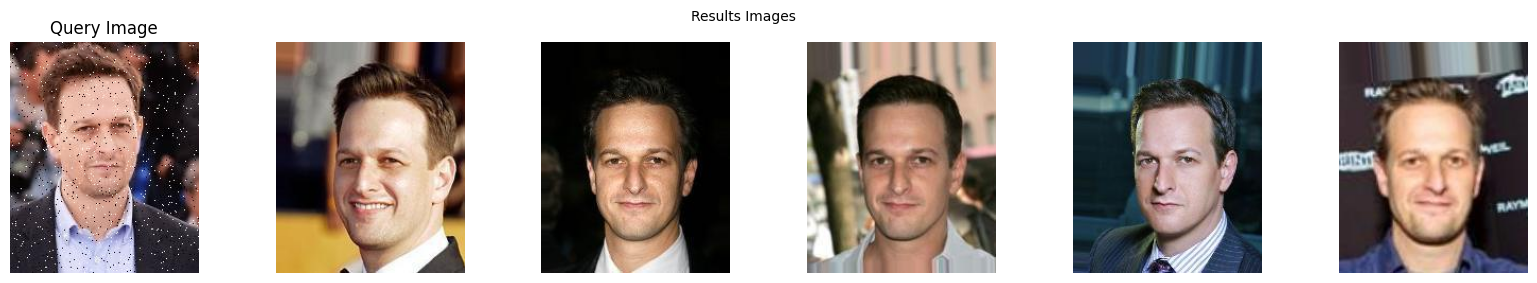

In [30]:
# Create a figure with 1 row and 6 columns
fig, axs = plt.subplots(1, 6, figsize=(20, 3))  # Adjust the figure size as needed

# Plot the first image with its title
axs[0].imshow(mpimg.imread(r'./data/josh-charles-noisy.jpg'), cmap='gray')
axs[0].set_title('Query Image')
axs[0].axis('off')  # Hide axes for cleaner look

counter = 0
# Plot the rest of the images
for ax in axs[1:]:
    ax.imshow(images[counter], cmap='gray')  # Replace images[1] with your specific images as necessary
    ax.axis('off')
    counter = counter + 1

# Set a common title for the last five images
fig.text(0.5, 0.95, 'Results Images', ha='center')  # Adjust y position as necessary for visibility

plt.show()

## Different person

In [31]:
query_vector = em.get_embedding(path=r'./data/random.jpg')
result = img_collection.search(query_vectors=[query_vector], limit=5)

In [32]:
for hits in result:
    for hit in hits:
        hit_id, hit_distance = hit['id'], hit['distance']
        print(f"{hit_id=}, {hit_distance=}")

        celeb_id, img_path = hit['entity']['celeb_id'], hit['entity']['img_path']
        print(f" > celeb_id={celeb_id}")
        print(f" > img_path={img_path}")
        print()

hit_id=455152533311670417, hit_distance=0.34438830614089966
 > celeb_id=4872
 > img_path=./data/img_align_celeba/026815.jpg

hit_id=455152910323568549, hit_distance=0.3378851115703583
 > celeb_id=3119
 > img_path=./data/img_align_celeba/039789.jpg

hit_id=455152533311670425, hit_distance=0.2869369685649872
 > celeb_id=4872
 > img_path=./data/img_align_celeba/059809.jpg

hit_id=455152910323568571, hit_distance=0.2788097858428955
 > celeb_id=3119
 > img_path=./data/img_align_celeba/152962.jpg

hit_id=455152656180420719, hit_distance=0.2724066376686096
 > celeb_id=9004
 > img_path=./data/img_align_celeba/099664.jpg



In [33]:
image_paths = [hit['entity']['img_path'] for hits in result for hit in hits]
images = [mpimg.imread(path) for path in image_paths]

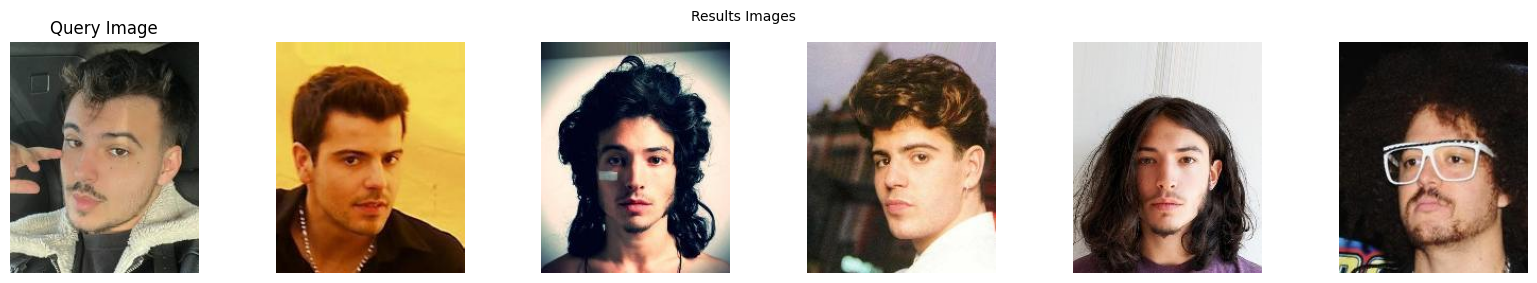

In [34]:
# Create a figure with 1 row and 6 columns
fig, axs = plt.subplots(1, 6, figsize=(20, 3))  # Adjust the figure size as needed

# Plot the first image with its title
axs[0].imshow(mpimg.imread(r'./data/random.jpg'), cmap='gray')
axs[0].set_title('Query Image')
axs[0].axis('off')  # Hide axes for cleaner look

counter = 0
# Plot the rest of the images
for ax in axs[1:]:
    ax.imshow(images[counter], cmap='gray')  # Replace images[1] with your specific images as necessary
    ax.axis('off')
    counter = counter + 1

# Set a common title for the last five images
fig.text(0.5, 0.95, 'Results Images', ha='center')  # Adjust y position as necessary for visibility

plt.show()